# Segment Anything Proof of Concept:

Baseline of code from an old tutorial provided by MRINAL MATHUR at https://www.kaggle.com/code/mrinalmathur/segment-anything-model-tutorial


# Introduction

The Segment Anything Model Allows us to create masks for virtually any set of images.  The following is a tutorial showing the process of training and executing the code


![SAM Image](https://assets-global.website-files.com/5d7b77b063a9066d83e1209c/6540e8930116ce87eca1566e_Hero%20-%20SAM.webp)

# Importing Libraries


In [ ]:
pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-3gv8lzt1
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-3gv8lzt1
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from PIL import Image
from segment_anything import sam_model_registry
from segment_anything import SamAutomaticMaskGenerator
import os
import cv2
import requests
from io import BytesIO
import matplotlib.pyplot as plt
from segment_anything import SamPredictor
from torch.utils.data import Dataset, DataLoader
import glob


import torch
import torch.nn as nn
import torchvision
from torchvision import transforms as pth_transforms
import numpy as np

import random



# Preprocess Data



In [ ]:
class Gem_Classifier(Dataset):
    def __init__(self, mainpath, transform=None):
        self.mainpath = mainpath
        self.transform = transform

        self.image_paths = sorted(glob.glob(os.path.join(mainpath, '*', '*.jpg')))

        # Print the number of loaded images
        print(f"Number of images: {len(self.image_paths)}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image


# Initialize Dataloaders

In [ ]:
train_root_dir = os.path.join("../input/sports-classification/train/")
valid_root_dir = os.path.join("../input/sports-classification/test/")

train_transform = pth_transforms.Compose([
    pth_transforms.ToTensor(),
])

valid_transform = pth_transforms.Compose([
    pth_transforms.Resize((256, 256)),
    pth_transforms.ToTensor(),
    pth_transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = Gem_Classifier(mainpath=train_root_dir, transform=train_transform)
valid_dataset = Gem_Classifier(mainpath=valid_root_dir, transform=valid_transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size= 8, shuffle=True, num_workers = 2)

Number of images: 13492
Number of images: 500


# Initializing SAM model:

In [ ]:
sam_checkpoint = '/kaggle/input/segment-anything/pytorch/vit-l/1/model.pth'
model_type = "vit_l" #Vision Transformer 1 (mentioned in slide 22)
device = "cuda" #cpu,cuda

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator1 = SamAutomaticMaskGenerator(sam, points_per_batch=16)
predictor = SamPredictor(sam)


(224, 224, 3)


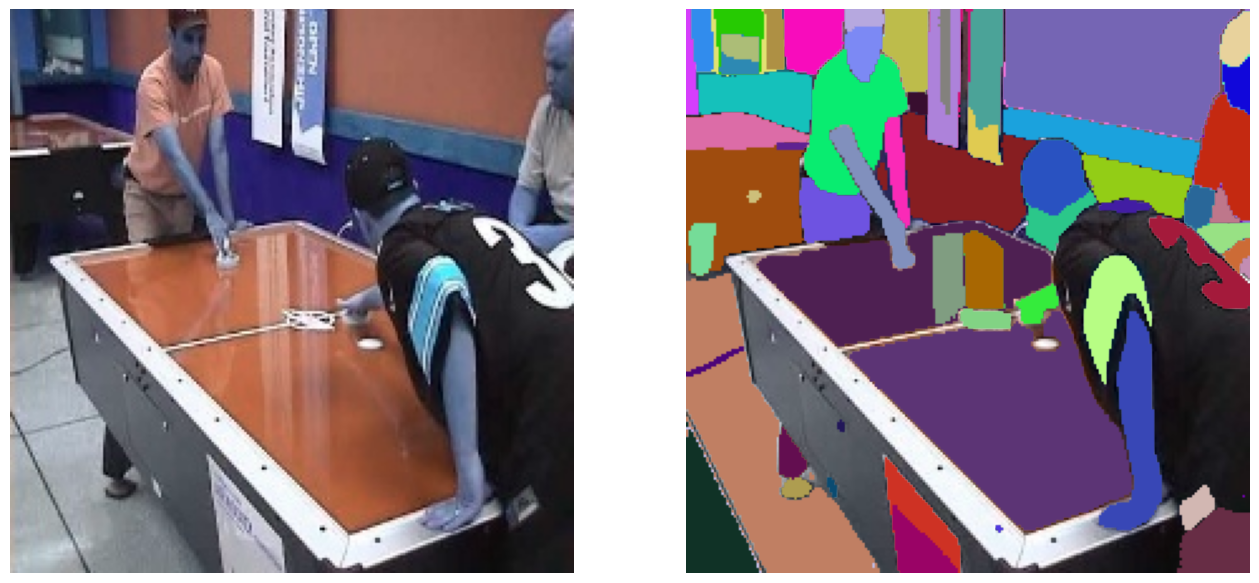

In [ ]:
def show_anns(anns, axes=None):
    if len(anns) == 0:
        return
    if axes:
        ax = axes
    else:
        ax = plt.gca()
        ax.set_autoscale_on(False)
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m**0.5)))

#Take a subeset of the images to use for training
num_images = 10
random_indices = random.sample(range(len(train_dataset)), num_images)
image_tensor= train_dataset[0]
image_path = "/kaggle/input/sports-classification/test/air hockey/1.jpg"
image_information = cv2.imread(image_path)
image = cv2.resize(image_information, (224,224))
masks = mask_generator1.generate(image)

image_np = image_tensor.numpy()
# Reshape the image data to a valid shape
image_data = np.moveaxis(image_np, 0, -1)  # Move the channels axis to the last position
print(image_data.shape)  # Output: (256, 256, 3)

# Show the Original Image and What was made by SAM
fig, axs = plt.subplots(1, 2, figsize=(16, 16))
axs[0].imshow(image)
axs[1].imshow(image)
show_anns(masks, axs[1])
axs[0].axis('off')
axs[1].axis('off')
plt.show()

